# Pre-processing scRNA-seq data with scanpy

Melissa Hubisz, mt269@cornell.edu

TREX x BioHPC Single cell RNA-workshop Week 4 exercise

### Notes about scanpy

Scanpy is a python package for analyzing single-cell data. It has many of the same types of functions offered by Seurat, but is also quite different.

One important difference is simply that the scRNA object is transposed, with each cell representing a row and each column representing a gene

The scRNA data is stored in an "AnnData" object (short for annotated data). The object has several fields:
- adata.X: count matrix
- adata.layers: a dictionary object, each element contains an alternative/transposed count matrices, i.e., adata.layers["logX"] may contain the log-normalized matrix
- adata.obs: a DataFrame with one row per cell, each column contains an annotation about the cell, i.e, sample name, condition, mtRNA fraction, library size
- adata.var: a DataFrame with one row per gene, each column represents an annotation about the gene, i.e., highly variable, short name, ensembl ID
- adata.obsm: a dictionary object, each element contains a matrix with a row per cell, but arbitrary number of columns. For example, adata.obsm['X_pca'] may contain principal components
- adata.varm: a dictionary object, each element contains a matrix with a row per gene, but arbitrary number of columns.
- adata.uns: a dictionary object, there are no restrictions on what can be stored in each element, can contain any further information. Often used to store PCA/UMAP parameters.

Scanpy has several types of functions, it helps to understand the naming conventions:
- sc.pp functions are 'preprocessing' functions (QC, highly variable genes, normalizing, nearest neighbors)
- sc.tl functions are 'tools': PC, UMAP, clustering, trajectory inference, marker genes
- sc.pl functions are plotting functions. There is usually a plotting function associated with each tool function. For example, compute UMAP with sc.tl.umap, plot it with sc.pl.umap
- sce is an auxiliary library for 'scanpy external' functions, where the main code is in another library but sce library contains wrappers to it

### Notes about working in jupyter notebooks

- each 'box' is called a cell, one cell is always selected
- There are two modes: Edit mode and Command Mode
    - `Enter` to enter edit mode
    - `Esc` to enter command mode
- In either mode:
    - `Shift`+`Enter` will execute cell and advance to next cell
    - `Ctrl`+`Enter` will execute cell without advancing
    - `Ctrl`+`s` to save notebook
    - `Ctrl`+`Shift`+`h` to open pop-up with keyboard shortcuts
- In Edit mode:
    - you will see a cursor in active cell
    - cell may be in __Code__ or __Markdown__ mode
    - In code mode, can use `Tab` to code completion, or `Shift`+`Tab` for function help (with cursor right after open parentheses of function)
    - `Ctrl`+`Shift`+`-` will split cell at cursor position
    - `Ctrl`+`z` to undo last edit
- In Command mode:
    - press `a` to add new cell *after* current cell
    - press `b` to add new cell *before* current cell
    - press `d`+`d` to delete current cell
    - press `m` to switch cell to markdown mode
    - press `y` to switch cell to code from markdown
    - press `z` to undo previous command mode operation
    - switching from markdown and back to code `ym` is fast way to clear output
    - `Shift`+`m` will merge current cell with next cell
- You can execute system commands within a cell using a line that starts with an exclamation point !  For example, you can install a library with a line like: `! pip install scrublet`. Make sure to save your image after installing any libraries


## Import python libraries

In [1]:
import os
import numpy as np
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import glob
import gc
import anndata2ri
import random
from sklearn.metrics.cluster import adjusted_rand_score
%load_ext rpy2.ipython

## Read in data

In this section, we find the h5 files to read in, and use the scanpy read_10x_h5 function to load them into an anndata structure. 

In [2]:
!mkdir -p /data/scanpy
os.chdir("/data/scanpy")

In [3]:
adata_files = glob.glob('/workdir/sc_workshop_2024/GSE201999_output/**/filtered_feature_bc_matrix.h5', recursive=True)
adata_files

['/workdir/sc_workshop_2024/GSE201999_output/TL-IgG4/outs/filtered_feature_bc_matrix.h5',
 '/workdir/sc_workshop_2024/GSE201999_output/TL-IgG1/outs/filtered_feature_bc_matrix.h5',
 '/workdir/sc_workshop_2024/GSE201999_output/Untreated/outs/filtered_feature_bc_matrix.h5']

In [4]:
adata_list = []
idx=1
for i,f in enumerate(adata_files):
    sampleName = f.split('/')[4].replace('_output', '')
    print(f'Reading sample {i}: {sampleName} from {f}')
    adata = sc.read_10x_h5(f)
    adata.var_names_make_unique()
    print('Done reading: numcell=' + str(adata.shape[0]) + ', numgene=' + str(adata.shape[1]))

    # add sample name annotation
    adata.obs['sample'] = sampleName

    # The cell name is barcode + '-1'. Change this to barcode + '-' + sample number
    adata.obs.index = [x.split('-')[0] + '-' + str(i+1) for x in adata.obs.index]

    adata_list.append(adata)

Reading sample 0: TL-IgG4 from /workdir/sc_workshop_2024/GSE201999_output/TL-IgG4/outs/filtered_feature_bc_matrix.h5


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Done reading: numcell=15039, numgene=36601
Reading sample 1: TL-IgG1 from /workdir/sc_workshop_2024/GSE201999_output/TL-IgG1/outs/filtered_feature_bc_matrix.h5


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Done reading: numcell=9689, numgene=36601
Reading sample 2: Untreated from /workdir/sc_workshop_2024/GSE201999_output/Untreated/outs/filtered_feature_bc_matrix.h5


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Done reading: numcell=13883, numgene=36601


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Concatenate

In [5]:
adata = sc.concat(adata_list)

In [6]:
adata

AnnData object with n_obs × n_vars = 38611 × 36601
    obs: 'sample'

In [7]:
adata.obs

,sample
AAACCCAAGACCAGCA-1,TL-IgG4
AAACCCAAGACTCGAG-1,TL-IgG4
AAACCCAAGCAATTAG-1,TL-IgG4
AAACCCAAGCCGAACA-1,TL-IgG4
AAACCCAAGCTGGCTC-1,TL-IgG4
...,...
TTTGTTGGTATAGGGC-3,Untreated
TTTGTTGGTCTGCCTT-3,Untreated
TTTGTTGGTTCTGAGT-3,Untreated
TTTGTTGGTTGTTTGG-3,Untreated


In [8]:
# this shows number of cells per sample
adata.obs['sample'].value_counts()

sample
TL-IgG4      15039
Untreated    13883
TL-IgG1       9689
Name: count, dtype: int64

### Annotate library size and mitochondrial fraction

note that adata.X is a sparse Matrix so it takes a bit of ugly code to convert the result to a 1-dimensional python array in the following cells

In [9]:
adata.obs['nCount_RNA'] = np.array(np.sum(adata.X, axis=1)).flatten()
adata.obs['nFeature_RNA'] = np.array(np.sum(adata.X > 0, axis=1)).flatten()

In [10]:
# also annotate number of expressing cells per gene
adata.var['nCell'] = np.array(np.sum(adata.X > 0, axis=0)).flatten()

In [11]:
mt_genes = [x for x in adata.var.index if x.startswith('MT-')]
mt_genes

['MT-ND1',
 'MT-ND2',
 'MT-CO1',
 'MT-CO2',
 'MT-ATP8',
 'MT-ATP6',
 'MT-CO3',
 'MT-ND3',
 'MT-ND4L',
 'MT-ND4',
 'MT-ND5',
 'MT-ND6',
 'MT-CYB']

In [12]:
adata.obs['mt_frac'] = np.array(np.sum(adata[:,mt_genes].X, axis=1)).flatten()/adata.obs['nCount_RNA']

In [13]:
adata.obs

,sample,nCount_RNA,nFeature_RNA,mt_frac
AAACCCAAGACCAGCA-1,TL-IgG4,891.0,359,0.506173
AAACCCAAGACTCGAG-1,TL-IgG4,12096.0,3520,0.053571
AAACCCAAGCAATTAG-1,TL-IgG4,33805.0,6176,0.027718
AAACCCAAGCCGAACA-1,TL-IgG4,8702.0,3070,0.064123
AAACCCAAGCTGGCTC-1,TL-IgG4,12689.0,3838,0.040586
...,...,...,...,...
TTTGTTGGTATAGGGC-3,Untreated,9973.0,2938,0.049835
TTTGTTGGTCTGCCTT-3,Untreated,7629.0,2779,0.038406
TTTGTTGGTTCTGAGT-3,Untreated,7331.0,2716,0.044469
TTTGTTGGTTGTTTGG-3,Untreated,11450.0,3398,0.039913


## Filter data

### Remove genes expressed by few cells

note: can alternatively use `sc.pp.filter_genes(adata, min_counts=10)`.  Usually, if I can get something done with a few lines of manual code, I prefer this over calling a function from some library. It is easier to know for sure what the code is doing.

In the first plot, we look at distribution of number of expressed cells per gene, and in the second plot, we zoom in to see the distribution closer to the potential cutoff.

Text(0, 0.5, 'NUmber of genes')

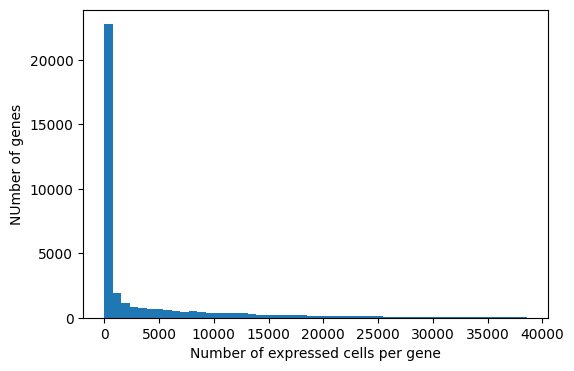

In [14]:
plt.subplots(figsize=(6,4))
plt.hist(adata.var['nCell'], bins=50)
plt.xlabel('Number of expressed cells per gene')
plt.ylabel('NUmber of genes')

Text(0, 0.5, 'NUmber of genes')

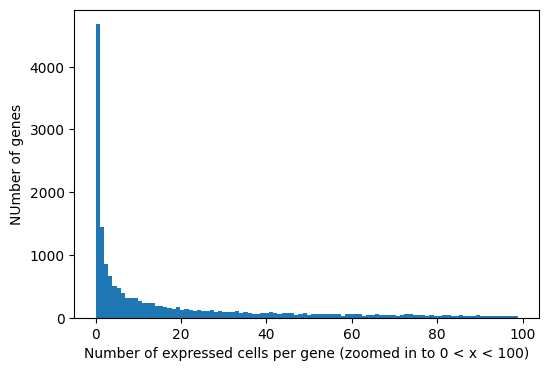

In [15]:
plt.subplots(figsize=(6,4))
plt.hist(adata.var.loc[adata.var['nCell'] < 100, 'nCell'], bins=100)
plt.xlabel('Number of expressed cells per gene (zoomed in to 0 < x < 100)')
plt.ylabel('NUmber of genes')

Now that we have looked at the distribution, we can choose a cutoff and filter genes

In [16]:
mincell = 10
f = adata.var['nCell'] < mincell
print('Removing ' + str(sum(f)) + ' genes expressed by fewer than ' + str(mincell) + ' cells')
adata = adata[:,~f]

Removing 9943 genes expressed by fewer than 10 cells


In [17]:
adata.shape

(38611, 26658)

### Remove cells with high mitochondrial content

The code below is a little ugly butmakes a nice 2d histogram showing mt_frac as a function of UMI count. There are many ways to visualize this.

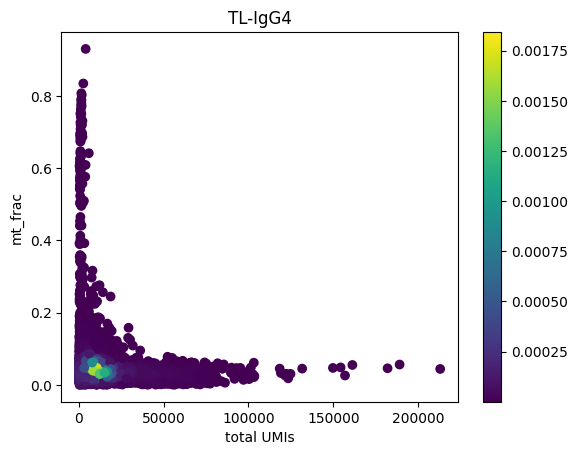

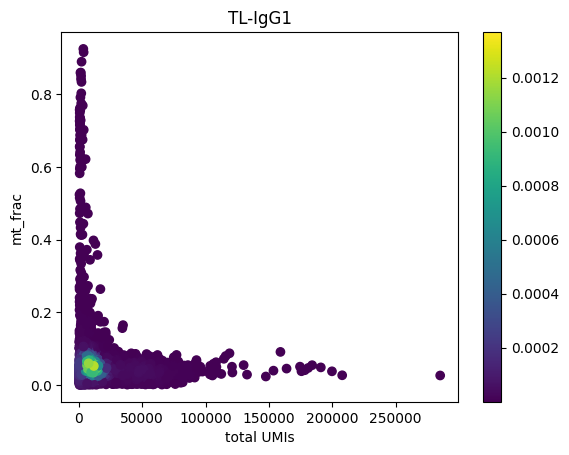

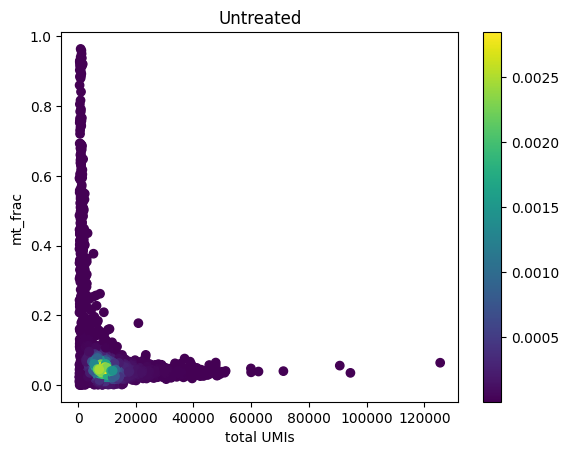

In [18]:
# first, plot mt_frac vs library size for each sample. Use gaussian_kde to make 2-d density plot
for sample in adata.obs['sample'].unique():
    f = adata.obs['sample'] == sample
    x = adata.obs.loc[f,'nCount_RNA']
    y = adata.obs.loc[f,'mt_frac']
    xy = np.vstack([x, y ])
    z = np.arcsinh(gaussian_kde(xy)(xy))
    plt.scatter(x, y, c=z)
    plt.xlabel('total UMIs')
    plt.ylabel('mt_frac')
    plt.title(sample)
    cb = plt.colorbar()
    plt.show()

### Explore distributions of metadata statistics

After looking at distributions, can choose appropriate cutoffs

In [19]:
adata.obs['NoveltyScore'] = np.log10(adata.obs['nFeature_RNA'])/np.log10(adata.obs['nCount_RNA'])

/tmp/ipykernel_948/2965978976.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['NoveltyScore'] = np.log10(adata.obs['nFeature_RNA'])/np.log10(adata.obs['nCount_RNA'])


In [20]:
adata.obs

,sample,nCount_RNA,nFeature_RNA,mt_frac,NoveltyScore
AAACCCAAGACCAGCA-1,TL-IgG4,891.0,359,0.506173,0.866170
AAACCCAAGACTCGAG-1,TL-IgG4,12096.0,3520,0.053571,0.868688
AAACCCAAGCAATTAG-1,TL-IgG4,33805.0,6176,0.027718,0.836989
AAACCCAAGCCGAACA-1,TL-IgG4,8702.0,3070,0.064123,0.885146
AAACCCAAGCTGGCTC-1,TL-IgG4,12689.0,3838,0.040586,0.873442
...,...,...,...,...,...
TTTGTTGGTATAGGGC-3,Untreated,9973.0,2938,0.049835,0.867268
TTTGTTGGTCTGCCTT-3,Untreated,7629.0,2779,0.038406,0.887036
TTTGTTGGTTCTGAGT-3,Untreated,7331.0,2716,0.044469,0.888431
TTTGTTGGTTGTTTGG-3,Untreated,11450.0,3398,0.039913,0.870015


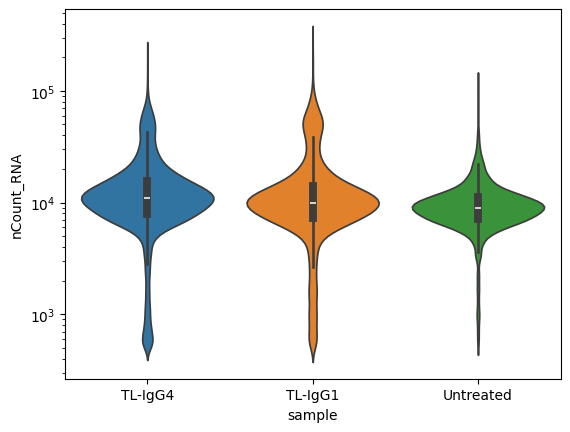

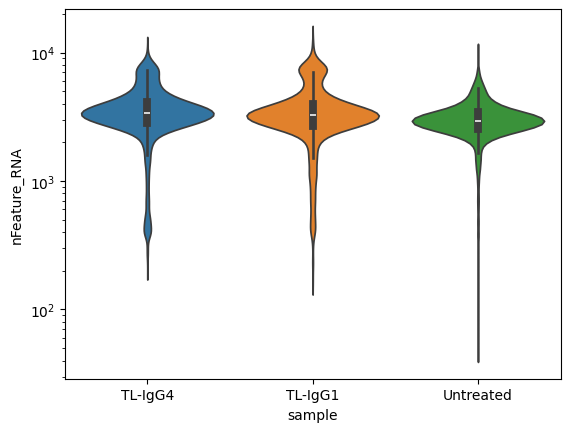

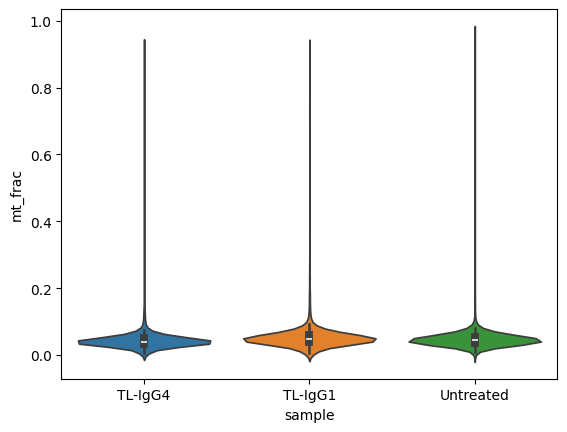

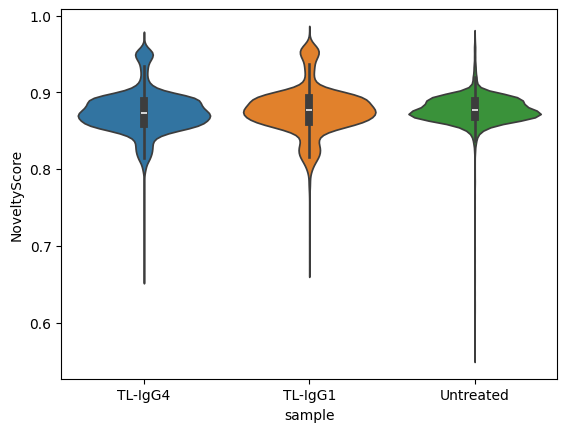

In [21]:
for x in adata.obs.columns[1:]:
    sns.violinplot(data=adata.obs, x='sample', hue='sample', y=x, log_scale=(x in ['nCount_RNA', 'nFeature_RNA']))
    plt.show()

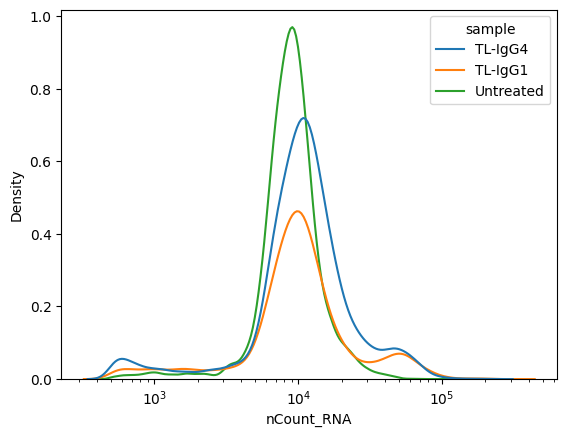

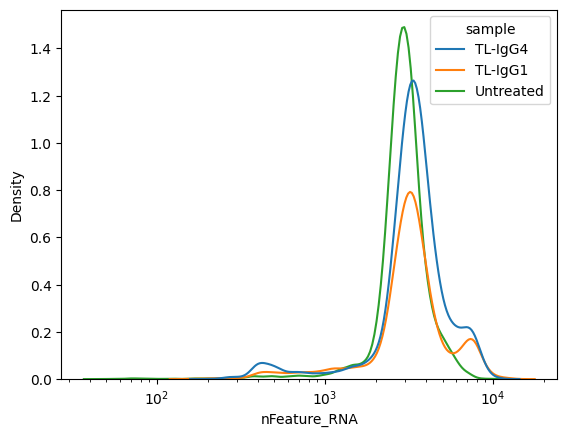

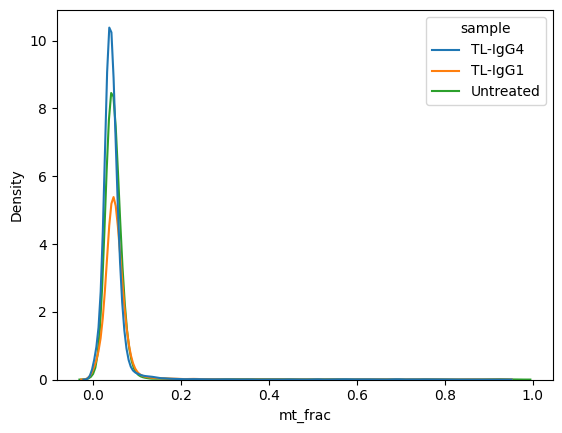

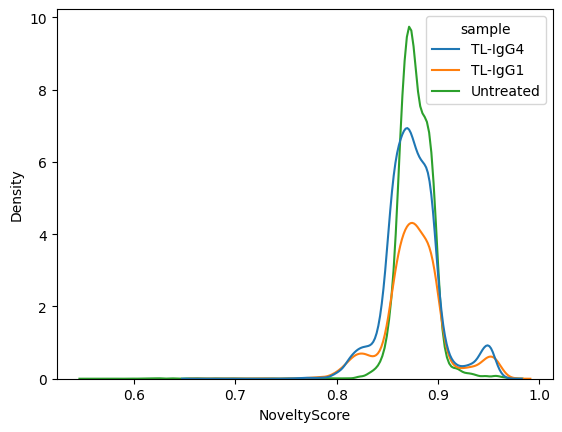

In [22]:
for x in adata.obs.columns[1:]:
    sns.kdeplot(data=adata.obs, x=x, hue='sample', fill=False, log_scale=(x in ['nCount_RNA', 'nFeature_RNA']))
    plt.show()

### Apply filters

In [23]:
adata.obs

,sample,nCount_RNA,nFeature_RNA,mt_frac,NoveltyScore
AAACCCAAGACCAGCA-1,TL-IgG4,891.0,359,0.506173,0.866170
AAACCCAAGACTCGAG-1,TL-IgG4,12096.0,3520,0.053571,0.868688
AAACCCAAGCAATTAG-1,TL-IgG4,33805.0,6176,0.027718,0.836989
AAACCCAAGCCGAACA-1,TL-IgG4,8702.0,3070,0.064123,0.885146
AAACCCAAGCTGGCTC-1,TL-IgG4,12689.0,3838,0.040586,0.873442
...,...,...,...,...,...
TTTGTTGGTATAGGGC-3,Untreated,9973.0,2938,0.049835,0.867268
TTTGTTGGTCTGCCTT-3,Untreated,7629.0,2779,0.038406,0.887036
TTTGTTGGTTCTGAGT-3,Untreated,7331.0,2716,0.044469,0.888431
TTTGTTGGTTGTTTGG-3,Untreated,11450.0,3398,0.039913,0.870015


In [24]:
f = (adata.obs['nFeature_RNA'] > 1000)  & (adata.obs['nFeature_RNA'] < 9000) & (adata.obs['mt_frac'] < 0.2) & (adata.obs['NoveltyScore'] > 0.8)
print(f'Removoing {sum(~f)} out of {len(f)} cells ({(sum(~f)/len(f)*100):0.1f}%) that do not pass filters')
adata.obs['pass_filter'] = f

Removoing 1919 out of 38611 cells (5.0%) that do not pass filters


In [25]:
# this just looks at fraction of cells passing filter per sample
adata.obs[['sample', 'pass_filter']].groupby('sample').mean()

,pass_filter
sample,
TL-IgG1,0.928579
TL-IgG4,0.941352
Untreated,0.975149


In [26]:
# now do the subsetting
adata = adata[adata.obs['pass_filter']]
print(adata.shape)

(36692, 26658)


## Log normalize

After log normalizing, adata.X to log-normalized version, as this is default that we will want to use for most analysis

In [27]:
sc.pp.normalize_total(adata, target_sum=10000, inplace=True)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [28]:
np.sum(adata.X, axis=1)

matrix([[10000.001],
        [10000.   ],
        [10000.001],
        ...,
        [10000.001],
        [ 9999.999],
        [ 9999.999]], dtype=float32)

In [29]:
np.max(adata.X)

2453.8638

In [30]:
adata.layers['logX'] = sc.pp.log1p(adata.X, copy=True)

In [31]:
adata.layers['X'] = adata.X
adata.X = adata.layers['logX']

In [32]:
np.max(adata.layers['X'])

2453.8638

In [33]:
np.max(adata.layers['logX'])

7.8058267

## Choose highly variable genes

In [34]:
sc.pp.highly_variable_genes(adata, layer='logX', n_top_genes=3000, flavor='seurat_v3', batch_key='sample')

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [35]:
adata.var

,nCell,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
AL627309.1,237,False,NaN,0.003329,0.002281,0.934836,0
AL627309.5,639,False,NaN,0.009018,0.005892,0.869158,0
AL669831.2,17,False,NaN,0.000236,0.000148,0.914338,0
LINC01409,6038,False,NaN,0.112629,0.083054,1.033332,0
FAM87B,68,False,NaN,0.001032,0.000694,0.926337,0
...,...,...,...,...,...,...,...
AL592183.1,1437,False,NaN,0.026182,0.021064,1.065445,0
AC240274.1,1801,False,NaN,0.024795,0.016243,0.857103,0
AC004556.3,36,False,NaN,0.000455,0.000274,0.902083,0
AC233755.1,21,False,2742.0,0.000317,0.000244,1.138148,1


In [36]:
np.sum(adata.var['highly_variable'])

3000

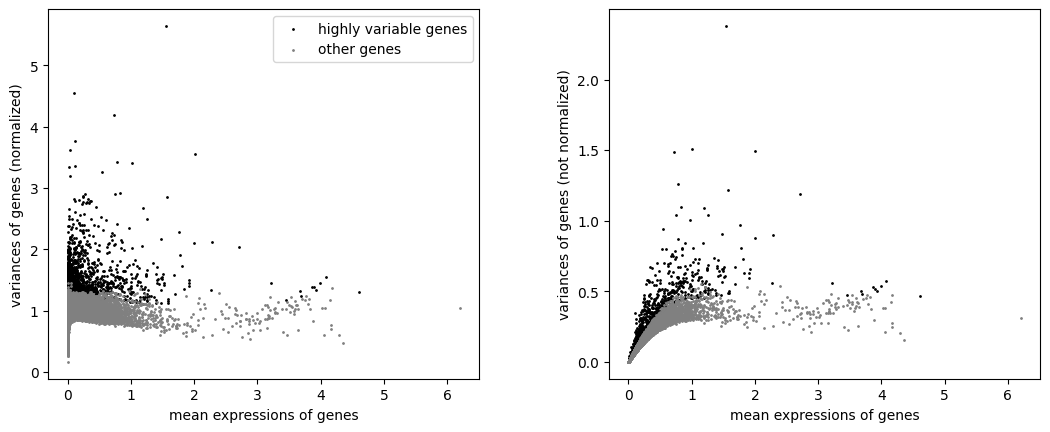

In [37]:
sc.pl.highly_variable_genes(adata)

In [38]:
hvgs = list(adata.var.loc[adata.var['highly_variable']].index)

Reduce data to only HVGs

In [39]:
adata = adata[:,hvgs]

## PCA

Here, we run PCA algorithm with large number of PCs (50), then look at the change in variance explained across the PCs. We then usually choose a number around the knee-point of this plot to be the actual number of PCs used for nearest neighbors  / UMAP projection.

In [40]:
adata

View of AnnData object with n_obs × n_vars = 36692 × 3000
    obs: 'sample', 'nCount_RNA', 'nFeature_RNA', 'mt_frac', 'NoveltyScore', 'pass_filter'
    var: 'nCell', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'logX', 'X'

In [41]:
# want to use log normalized data for PCA analysis
adata.X = adata.layers['logX']

In [42]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


We look at the variance ratio plot to decide how many PCs should be used. Usually choose the 'elbow' of the plot, here it seems to be around 10

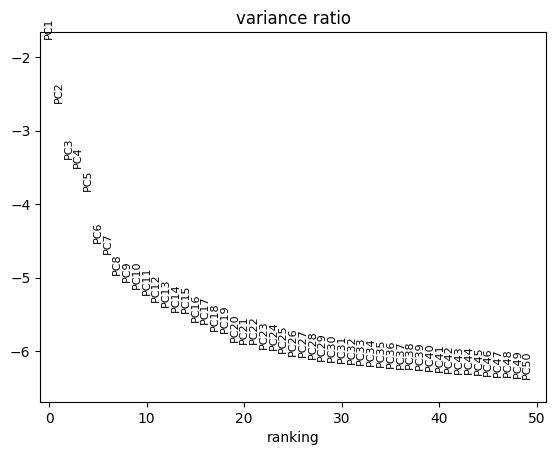

In [43]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

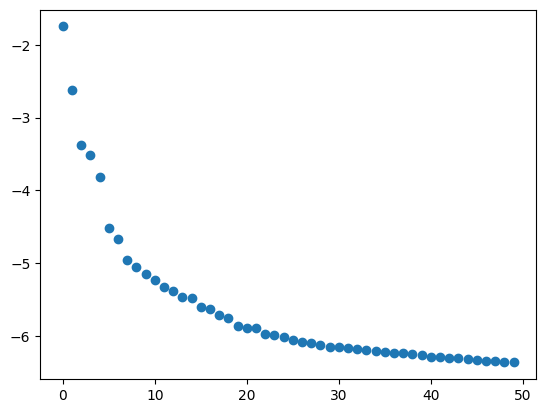

In [44]:
# This is equivalent of scanpy function above, to demonstrate where the data is coming from
plt.scatter(np.arange(50),
            np.log(adata.uns['pca']['variance_ratio']))

In [45]:
# this sets the order of the samples and assigns each sample to a color that will be used for scanpy plots
adata.obs['sample'] = pd.Categorical(adata.obs['sample'], categories=['TL-IgG1', 'TL-IgG4', 'Untreated'])
adata.uns['sample_colors'] = ['#ff7f0e', '#2ca02c', '#1f77b4']

In [46]:
adata.obs['sample'].value_counts()

sample
TL-IgG4      14157
Untreated    13538
TL-IgG1       8997
Name: count, dtype: int64

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


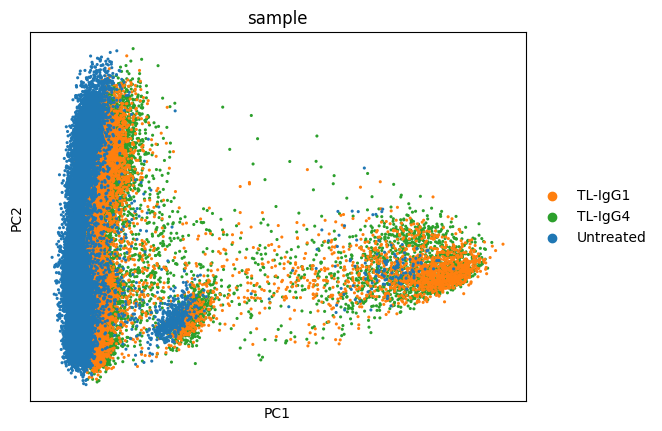

In [47]:
sc.pl.pca(adata, color='sample', size=20)

In [48]:
__Check: the adata structure is sorted by sample, so is the last sample being plotted on top? Try randomizing cells in adata structure__

SyntaxError: invalid syntax (915640076.py, line 1)

In [ ]:
# just demonstrating that adata.obs is sorted by sample
adata.obs

In [ ]:
# random.sample(list, n) samples n objects from list without replacement
# so Our list is the cell names (adata.obs.index), and adata.shape[0] is the total number of cells, so this command returns shuffled list of cells
ridx = random.sample(list(adata.obs.index), adata.shape[0])

In [ ]:
sc.pl.pca(adata[ridx], color='sample', size=20)

__This result is a bit easier to interpret. So keep the randomized indexes__

In [ ]:
adata = adata[ridx]

In [ ]:
adata.obs

In [ ]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30)
sc.tl.umap(adata, min_dist=0.3, spread=1.0)

In [ ]:
sc.pl.umap(adata, color='sample', s=10, alpha=0.5)

## Clustering
Try Louvain clustering algorithm

In [ ]:
# try three different resolutions
for res in [0.25, 0.5, 1]:
    key = f'louvain_{res:0.2f}'
    sc.tl.louvain(adata, resolution=res, key_added=key)
    sc.pl.umap(adata, color=key)
    plt.show()

## Load clusters/UMAP from previous week's analysis in Seurat and see how they compare

This next cell represents 'R magic' in jupyter.

The %%R means run this cell in R. It opens an R kernel 

The -o XXX means to 'output' the variable that will be created in R, back into the python notebook

You can also use -i XXX to input from python into the R cell.

There are some tools that claim to make R magic work with Seurat objects but I have not had luck with any but the simplest objects. But R magic does seem to work on basic R objects including data frames

In [ ]:
%%R -o seurat_metadata -o seurat_umap
require("Seurat")
sobj <- readRDS("/workdir/sc_workshop_2024/Seurat/03_sobj.clustered.RDS")
seurat_umap <- sobj[["umap.unintegrated"]]@cell.embeddings
seurat_metadata = sobj@meta.data
rm(sobj)

In [ ]:
seurat_umap

In [ ]:
seurat_metadata

In [ ]:
seurat_metadata['umap1'] = seurat_umap[:,0]
seurat_metadata['umap2'] = seurat_umap[:,1]

In [ ]:
adata.obs

As you can see, there is a mismatch in cell barcodes in the seurat and adata metadata. The seurat ones end in -1_X where X represents the sample. The adata ones end in -1_X2 where X2 is also a sample number, but the mapping is not the same. So we need to fix the seurat barcodes to match adata ones

In [ ]:
# this code makes a mapping of sample numbers to numbers at the end of the adata barcodes
tmp = adata.obs[['sample']].copy()
tmp['sample-suffix'] = [x.split('-')[1] for x in tmp.index]
sample_map = tmp.set_index('sample').to_dict()['sample-suffix']
sample_map

In [ ]:
seurat_metadata['new_barcode'] = [x.split('-')[0] for x in seurat_metadata.index] 
seurat_metadata['sample_num'] = [sample_map[x] for x in seurat_metadata['orig.ident']]
seurat_metadata['new_barcode'] = seurat_metadata['new_barcode']  + '-' + seurat_metadata['sample_num']
seurat_metadata.set_index('new_barcode', drop=True, inplace=True)

In [ ]:
# check the barcodes should be fixed now
seurat_metadata

In [ ]:
# merge adata.obs with Seurat metadata into one data frame
merged_metadata = adata.obs.merge(seurat_metadata, left_index=True, right_index=True, how='inner', suffixes=('', '_seurat'))

In [ ]:
merged_metadata

Now we have both sets of clusters in the same data frame, we can compare

In [ ]:
adjusted_rand_score(merged_metadata['seurat_clusters'], merged_metadata['louvain_1.00'])

In [ ]:
adjusted_rand_score(merged_metadata['seurat_clusters'], merged_metadata['louvain_0.50'])

In [ ]:
adjusted_rand_score(merged_metadata['seurat_clusters'], merged_metadata['louvain_0.25'])

In [ ]:
adjusted_rand_score(merged_metadata['louvain_0.25'], merged_metadata['louvain_0.50'])

In [ ]:
adjusted_rand_score(merged_metadata['louvain_0.50'], merged_metadata['louvain_1.00'])

In [ ]:
# This plot is a heatmap, the color represents how many cells assigned to a given Louvain / Seurat cluster combination
counts = merged_metadata[['seurat_clusters', 'louvain_1.00']].value_counts().reset_index().pivot(index='seurat_clusters', columns='louvain_1.00', values='count')
counts[np.isnan(counts)] = 0
plt.imshow(counts, cmap='Greys')
plt.ylabel('seurat cluster')
plt.xlabel('louvain_cluster')

In [ ]:
# same plot as above but colors are on a log scale, helps to see outliers
plt.imshow(np.log(counts+1), cmap='Greys')
plt.ylabel('seurat cluster')
plt.xlabel('louvain_cluster')

Overall it appears that the clustering is reasonably similar, though with some noise in a small fraction of cells

## Harmony integration

There are several integration methods available in the scanpy external API, see https://scanpy.readthedocs.io/en/stable/external.html

Besides harmony, there is scanorama, bbknn, mnn_correct

In [ ]:
sce.pp.harmony_integrate(adata, key='sample')

In [ ]:
# Check - the harmony integration added obsm['X_pca_harmony'] to the adata structure
adata

In [ ]:
sc.pl.embedding(adata, basis='X_pca_harmony', color='sample', s=20)

Redo UMAP with new PCs

In [ ]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30, use_rep='X_pca_harmony', key_added='neighbors_harmony')
adata.obsm['X_umap_orig'] = adata.obsm['X_umap'].copy()
sc.tl.umap(adata, min_dist=0.3, spread=1.0, neighbors_key='neighbors_harmony')
adata.obsm['X_umap_harmony'] = adata.obsm['X_umap'].copy()
adata.obsm['X_umap'] = adata.obsm['X_umap_orig']

In [ ]:
sc.pl.embedding(adata, basis='X_umap_harmony', color='sample', s=20)

In [ ]:
adata

Clustering with harmony-corrected data

In [ ]:
sc.tl.louvain(adata, resolution=1.0, key_added='louvain_1.0_harmony', neighbors_key='neighbors_harmony')

In [ ]:
sc.pl.embedding(adata, basis='X_umap_harmony', color='louvain_1.0_harmony')

In [ ]:
merged_metadata = adata.obs.merge(seurat_metadata, left_index=True, right_index=True, how='inner', suffixes=('', '_seurat'))

In [ ]:
merged_metadata

In [ ]:
adjusted_rand_score(merged_metadata['louvain_1.0_harmony'], merged_metadata['seurat_clusters'])

In [ ]:
adjusted_rand_score(merged_metadata['louvain_1.0_harmony'], merged_metadata['louvain_1.00'])

## Find markers

scanpy has a function rank_genes_groups that can find DE genes betllsween groups of cells.

It can use several methods, including t-test (default), logistic regression, wilcox

After running, results are saved to adata.uns['rank_genes_groups'] (unless a different key_added option is added in function call)

In [ ]:
# This will compute differential expression scores for each cluster vs all others
sc.tl.rank_genes_groups(adata, groupby='louvain_1.0_harmony', method='t-test')

In [ ]:
adata.uns['rank_genes_groups']['params']

In [ ]:
# The data strucutre returned by rank_genes_groups is a bit ocmplex to parse,
# but scanpy provides an easy function to turn it into a data frame

df = sc.get.rank_genes_groups_df(adata, group=None)
df

In [ ]:
df.loc[df['group']=='0']

In [ ]:
# Here are two top genes that differentiate cluster 0 vs all others (one positive, one negative)

# As you can see these genes are generally differentially expressed but do not 'define' cluster 0. 
sc.pl.embedding(adata, basis='X_umap_harmony', color=['louvain_1.0_harmony', 'LTB', 'NKG7'])

In [ ]:
# To get genes that 'define' cluster zero it may be better to compare it to neighboring clusters
sc.tl.rank_genes_groups(adata, groupby='louvain_1.0_harmony', groups=['0', '1'])

In [ ]:
small_adata = adata[adata.obs['louvain_1.0_harmony'].isin(['0','1'])].copy()
sc.tl.rank_genes_groups(small_adata, 'louvain_1.0_harmony')
df2 = sc.get.rank_genes_groups_df(small_adata, group=None)
del(small_adata)
df2.loc[df2['group'] == '0']

In [ ]:
# Now we see some genes that really definwe cluster 0
sc.pl.embedding(adata, basis='X_umap_harmony', color=['louvain_1.0_harmony', 'LEF1', 'KLRB1'])

## Imputation

This command takes a long time! 


To demonstrate, we will use it on a small number of HVGs from clusters 0 and 1 only

In [ ]:
f = adata.obs['louvain_1.0_harmony'].isin(['0', '1'])
small_adata = adata[f, ].copy()

In [ ]:
small_adata.layers['X'][:100,:5]

In [ ]:
# recall HVGs in this small set
sc.pp.highly_variable_genes(small_adata, layer='logX', n_top_genes=100, flavor='seurat_v3', batch_key='sample')

In [ ]:
small_adata

In [ ]:
small_hvgs = list(small_adata.var.loc[small_adata.var['highly_variable']].index)
len(small_hvgs)

Note: Normally, when subsetting to a subset of the data (such as a cell type), you would redo PC and UMAP. For the sake of time we will skip that, you may try as an exercise. Make sure to first redo neighbors, as that is input to the PC algorithm.

In [ ]:
small_adata = small_adata[:,small_hvgs]

In [ ]:
testgenes = ['S100A4', 'AL136456.1', 'BTG2', 'LINC01871', 'MARCKS']

In [ ]:
#testgenes = list(small_adata.var.index[:4])
sc.pl.umap(small_adata, color=testgenes, ncols=3, cmap='Greys')

The magic algorithm returns an andata with imputed expression values in the .X matrix for the genes requested

In [ ]:
mdata = sce.pp.magic(small_adata, name_list=testgenes)

In [ ]:
mdata

In [ ]:
mdata.obsm['X_umap'] = small_adata.obsm['X_umap']

Compare UMAP of imputed expression to what we saw earlier

In [ ]:
sc.pl.umap(mdata, color=['louvain_1.0_harmony'] + testgenes, ncols=3, cmap='Greys')

Look at distribution of gene expression before/after magic imputation.

In [ ]:
gene = testgenes[0]
plt.hist(np.array(mdata[:,gene].X).flatten(), bins=50, alpha=0.5, label='Imputed')
plt.hist(np.array(small_adata[:,gene].X.todense()).flatten(), bins=50, alpha=0.5, label='Un-imputed')
plt.legend()

In [ ]:
plt.scatter(np.array(small_adata[:,gene].X.todense()).flatten(),
            np.array(mdata[:,gene].X).flatten(), alpha=0.2)
plt.xlabel('Unimputed LEF1 expression')
plt.ylabel('imputed LEF1 expression')

What did imputation do to the distribution? 

## Write adata to disk

In [ ]:
adata.write(f'adata_save.h5ad')

Can we load this data in R? Let's try some magic

In [ ]:
%%R 
require("rhdf5")   #This is R package for reading h5 files
## given h5ad anndata file, return given column from adata.obs
readObsFromh5File <- function(infile, colname) {
    tmp <- h5ls(infile)
    w <- which(tmp$name == colname & tmp$otype=="H5I_DATASET")
    if (length(w) == 1) {
        return(h5read(infile, sprintf("/obs/%s", colname)))
    }
    w <- which(tmp$group == sprintf("/obs/%s", colname))
    if (length(w) == 1) {
        return(h5read(infile, sprintf("/obs/%s", colname)))
    }
    if (length(w) == 2) {
        w2 <- which(tmp[w,]$name=="categories")
        catNames <- h5read(infile, sprintf("%s/%s", tmp[w,][w2,"group"], tmp[w,][w2,"name"]))
        w2 <- which(tmp[w,]$name == "codes")
        return(catNames[as.numeric(h5read(infile, sprintf("%s/%s", tmp[w,][w2, "group"], tmp[w,][w2, "name"])))+1])
    }
    stop("Error reading ", colname, " from ", infile)
}


infile <- "adata_save.h5ad"
counts <- h5read(infile, "/layers/logX")
cellNames <- as.character(h5read(infile, "/obs/_index"))
geneNames <- as.character(h5read(infile, "/var/_index"))
samples <- as.character(readObsFromh5File(infile, "sample"))
print(table(samples))

In [ ]:
%%R
print(length(geneNames))
print(class(counts))
print(names(counts))